<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




# Задание

Кликкер для колаба, чтобы он не отваливался

In [1]:
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>

In [2]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>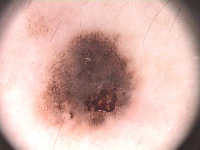</td><td>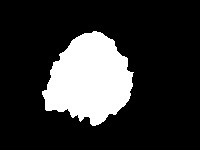</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [3]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2023-04-17 13:19:56--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2023-04-17 13:19:57--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccd26e4bf6f8705372e753466d8.dl.dropboxusercontent.com/cd/0/inline/B6Wi3olh5Ck6cmMoOTyxZM3Qu8Z3JUc1nYYWYYPxdp_1aswqMMB1MVuv6tr1GbDNp2ZtT7-tCgRwIDxylj-FttC0sKIwrlJ_YrZgnUu-fAP3HPdZqEoGVfF-QFnMKskTAfrJmo_9-hOn4EsOEXXsBoDkHfaSHrph6gOVLLz-KTx6nQ/file# [following]
--2023-04-17 13:19:57--  https://uccd26e4bf6f8705372e753466d8.dl.dropboxusercontent.com/cd/0/inline/B6Wi3olh5Ck6cmMoOTyxZM3Qu8Z3JUc1nYYWYYPxdp_1aswqMMB1MVuv6tr1GbDNp2ZtT7-tCg

In [4]:
!ls

PH2Dataset.rar	sample_data


In [5]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [7]:
import torch
import torch.nn as nn
from time import time
from matplotlib import rcParams
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from skimage.transform import resize
from skimage.io import imread
import torchvision
from torch.nn import BCEWithLogitsLoss
from torchvision import transforms
import pickle as pkl
from scipy.ndimage import distance_transform_edt as eucl_distance
import os
import copy

# rcParams['figure.figsize'] = (30,8)
torch.manual_seed(12)
torch.cuda.manual_seed(12)
np.random.seed(12)

In [8]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

# images = [imread(img) for img in sorted(images)]
# lesions = [imread(img) for img in sorted(lesions)]

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [9]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [10]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [11]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

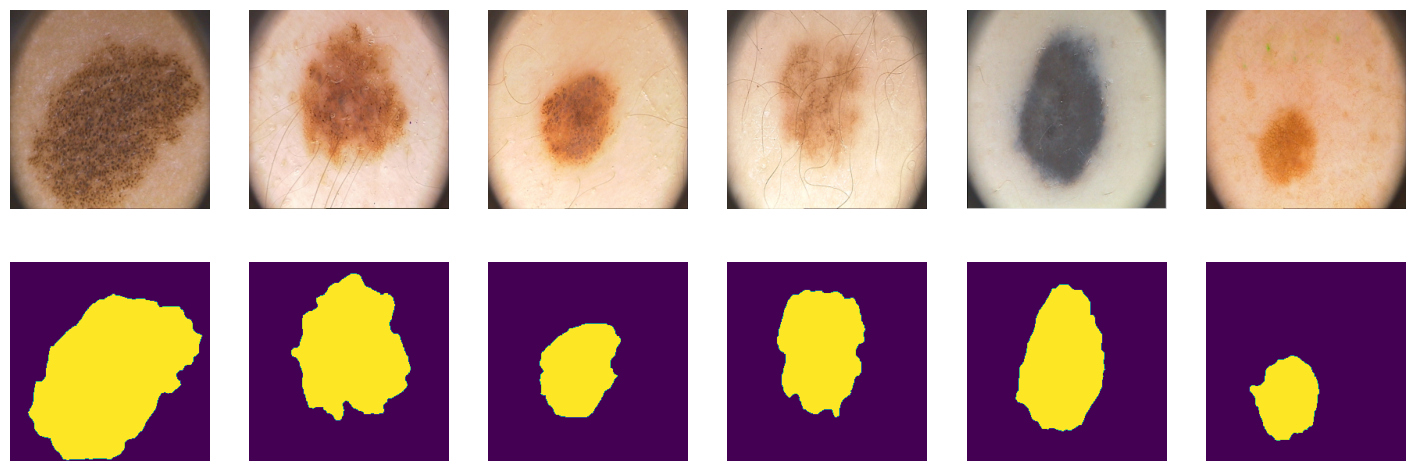

In [12]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [13]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [14]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [15]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [16]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

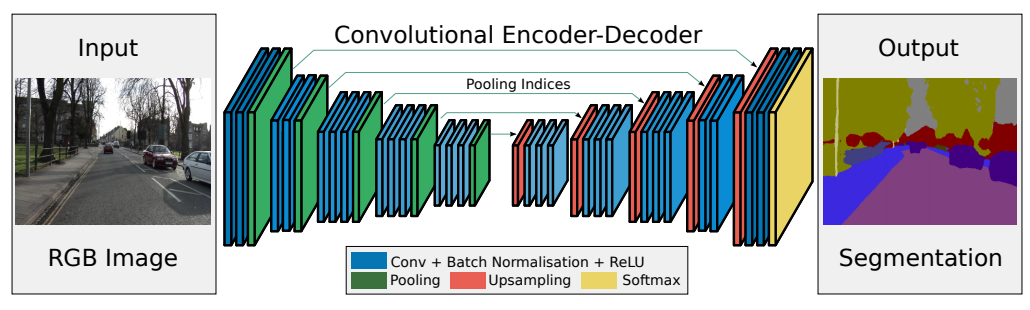

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [18]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_enc = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )
        self.bottleneck_pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.bottleneck_unpool = nn.MaxUnpool2d(2, 2)
        self.bottleneck_dec = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.upsample3 = nn.MaxUnpool2d(2, 2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1)
            )

    def forward(self, x):
        # encoder
        e0,id0 = self.pool0(self.enc_conv0(x))
        e1,id1 = self.pool1(self.enc_conv1(e0))
        e2,id2 = self.pool2(self.enc_conv2(e1))
        e3,id3 =self.pool3(self.enc_conv3(e2))

        b = self.bottleneck_enc(e3)
        b_pool, idb = self.bottleneck_pool(b)
        b = self.bottleneck_unpool(b_pool, idb, output_size=b.size())
        b = self.bottleneck_dec(b) 

        # decoder
        d0 = self.dec_conv0(self.upsample0(b,id3))
        d1 = self.dec_conv1(self.upsample1(d0,id2))
        d2 = self.dec_conv2(self.upsample2(d1,id1))
        d3 = self.dec_conv3(self.upsample3(d2,id0))  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [19]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    # thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    # return thresholded  # 
    return iou.mean()# thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [20]:
def bce(y_real, y_pred):
    return (torch.maximum(y_pred, torch.zeros_like(y_pred)) - y_real * y_pred + torch.log(1 + torch.exp(-torch.abs(y_pred))))

In [21]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    # max(x, 0) - x * z + log(1 + exp(-abs(x)))
    # BCEWithLogitsLoss()
    return bce(y_real, y_pred).mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [22]:
# def train(model, loss_fn, epochs, data_tr, data_val, name='model', aug=True, boundary=False):
def train(model, loss_fn, epochs, data_tr, data_val, name='model', boundary=False):
    torch.cuda.empty_cache()
    X_val, Y_val = next(iter(data_val))

    train_history = []
    val_history = []
    tr_score = []
    val_score = []
    test_score = []

    path = f"/content/gdrive/MyDrive/Colab Notebooks/DLS Course/{name}"#.pth"
    # best = f'{name}.pth'

    optim = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.95)
    # scheduler2 = torch.optim.lr_scheduler.StepLR(optim, step_size=30, gamma=0.5)
    
    # if loss is boundary-loss, then initiliaze alpha for optimize loss
    if boundary:
        alpha=0.01
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_score = 0.0
    # min_loss = 1e6
    
    # # augmentations
    # if aug:
    #     X_aug = transforms.Compose([
    #     transforms.RandomHorizontalFlip(p=1),
    #     transforms.RandomAdjustSharpness(.9, p=0.5),
    #     transforms.RandomApply([transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6)], p=0.5),
    #     transforms.RandomApply([transforms.Grayscale(3),], p=0.5)
    #     ])
        
    #     Y_aug = transforms.Compose([
    #     transforms.RandomHorizontalFlip(p=1),
    #     ])

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_tr_score = 0

        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)            
            # # apply augmentations
            # if aug:
            #     a = torch.randn(1).item()
            #     # prob of augmentation = 0.5
            #     if a > 0:
            #         X_batch = X_aug(X_batch)
            #         Y_batch = Y_aug(Y_batch)
            # set parameter gradients to zero
            optim.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) if not boundary else loss_fn(Y_batch, Y_pred, alpha)
            score = iou_pytorch(torch.sigmoid(Y_pred) > 0.5, Y_batch).item()
            loss.backward()  # backward-pass
            optim.step()  # update weights
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            avg_tr_score += score / len(data_tr)
        train_history.append(avg_loss.detach().cpu())
        tr_score.append(avg_tr_score)
        toc = time()
        print('loss: %f' % avg_loss)
        
        # show intermediate results
        model.eval()  # testing mode
        avg_loss_val = 0
        avg_val_score = 0
        with torch.no_grad():
            Y_hat = torch.sigmoid(model(X_val.to(device))).detach().cpu()  # detach and put into cpu 
            for X_batch, Y_batch in data_val:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                outp = model(X_batch)
                loss_val = loss_fn(Y_batch, outp) if not boundary else loss_fn(Y_batch, outp, alpha)
                avg_loss_val += loss_val / len(data_val)
                preds = torch.sigmoid(outp) > 0.5
                score = iou_pytorch(preds, Y_batch)
                avg_val_score += score / len(data_val)
            val_history.append(avg_loss_val.cpu())
            val_score.append(avg_val_score.cpu())  
            test_score.append(score_model(model,iou_pytorch,data_ts)) 
        print('val loss: %f' % avg_loss_val)
        
        scheduler1.step()
        # scheduler2.step()
        # strategy of selection alpha - start with 0.01 and increase by 0.01 every epoch
        if boundary:
            alpha += 0.01

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(4, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')
            
            plt.subplot(4, 6, k+7)
            plt.imshow(np.rollaxis(Y_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Ground truth')
            plt.axis('off')
            
            plt.subplot(4, 6, k+13)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Сonfidence')
            plt.axis('off')

            plt.subplot(4, 6, k+19)
            plt.imshow(Y_hat[k, 0] > 0.5, cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f; val_loss: %f; score: %f' % (epoch+1, epochs, avg_loss, avg_loss_val, avg_val_score))
        plt.show()

        if avg_val_score > best_score:
        # if avg_loss_val < min_loss:
                min_loss = avg_loss_val
                best_score = avg_val_score
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({'epoch': epoch,
                            'weights': best_model_wts,
                            'optim': optim.state_dict(),
                            'sched1': scheduler1.state_dict(),
                            # 'sched2': scheduler2.state_dict(),
                            'loss': min_loss,
                            'score': best_score,
                            }, f'{path}.pth')
        
    del X_batch, Y_batch, outp, preds, loss
        
    history = {'tr_losses':train_history, 
               'val_losses': val_history, 
               'path': path, 
               'name': name,
               'tr_score': tr_score, 
               'val_score': val_score,
               'test_score': test_score}
    model.load_state_dict(best_model_wts)
    torch.cuda.empty_cache()
    return history

Напишем класс вспомогательных функция для нашей модели.

In [81]:
class model_history():
    """
    Class for different operations with different models
        - Save model dict
        - Load model dict
        - Print figure
    """
    def __init__(self):
        None
    # def __init__(self,history):
    #     self.history={}
        # self.history=history

    def save(self, history: dict):
        # with open(f'./{name}.pkl', 'wb') as f:
        with open(f"{history['path']}.pkl", 'wb') as f: 
            pkl.dump(history, f)

    def load(self, name: str):
        with open(f"/content/gdrive/MyDrive/Colab Notebooks/DLS Course/{name}.pkl", 'rb') as f:
            history = pkl.load(f)
        return history

    def plot(self, history: dict):
        _, axes = plt.subplots(1, 2, figsize=(15,6), sharey=True)
        axes[0].plot(range(max_epochs), history['tr_losses'], label='train_loss')
        axes[0].plot(range(max_epochs), history['val_losses'], label='val_loss')
        axes[0].set_title('Loss(epoch)')
        axes[0].legend()
        axes[0].grid(True)
        axes[1].plot(range(max_epochs), history['tr_score'], label='train_score')
        axes[1].plot(range(max_epochs), history['val_score'], label='val_score')
        axes[1].plot(range(max_epochs), history['test_score'], label='test_score')
        axes[1].set_title('Score(epoch)')
        axes[1].legend()
        axes[1].grid(True)
        plt.suptitle(history['name'])

    def plot_summary(self, names: dict):
        _, axes = plt.subplots(12, 1, figsize=(10,45))
        for name in names:
            hist = self.load(name)
            if 'segnet' in name:
                axes[0].plot(range(max_epochs), hist['val_losses'], label=name)
                axes[1].plot(range(max_epochs), hist['val_score'], label=name)
                axes[2].plot(range(max_epochs), hist['test_score'], label=name)
            elif 'unet_' in name and 'unet_o' not in name:
                axes[3].plot(range(max_epochs), hist['val_losses'], label=name)
                axes[4].plot(range(max_epochs), hist['val_score'], label=name)
                axes[5].plot(range(max_epochs), hist['test_score'], label=name)
            elif 'unet_overlap' in name:
                axes[6].plot(range(max_epochs), hist['tr_losses'], label=name)
                axes[7].plot(range(max_epochs), hist['tr_score'], label=name)
                axes[8].plot(range(max_epochs), hist['test_score'], label=name)
            elif 'unet2' in name:
                axes[9].plot(range(max_epochs), hist['tr_losses'], label=name)
                axes[10].plot(range(max_epochs), hist['tr_score'], label=name)
                axes[11].plot(range(max_epochs), hist['test_score'], label=name)

        axes[0].set_title('Segnet Validation Loss(epoch)')
        axes[0].legend()
        axes[0].grid(True)

        axes[1].set_title('Segnet Validation Score(epoch)')
        axes[1].legend()
        axes[1].grid(True)

        axes[2].set_title('Segnet Test Score(epoch)')
        axes[2].legend()
        axes[2].grid(True)

        axes[3].set_title('Unet Validation Loss(epoch)')
        axes[3].legend()
        axes[3].grid(True)

        axes[4].set_title('Unet Validation Score(epoch)')
        axes[4].legend()
        axes[4].grid(True)

        axes[5].set_title('Unet Test Score(epoch)')
        axes[5].legend()
        axes[5].grid(True)

        axes[6].set_title('Unet Mirror Validation Loss(epoch)')
        axes[6].legend()
        axes[6].grid(True)

        axes[7].set_title('Unet Mirror Validation Score(epoch)')
        axes[7].legend()
        axes[7].grid(True)

        axes[8].set_title('Unet Mirror Test Score(epoch)')
        axes[8].legend()
        axes[8].grid(True)

        axes[9].set_title('Unet2 Validation Loss(epoch)')
        axes[9].legend()
        axes[9].grid(True)

        axes[10].set_title('Unet2 Validation Score(epoch)')
        axes[10].legend()
        axes[10].grid(True)

        axes[11].set_title('Unet2 Test Score(epoch)')
        axes[11].legend()
        axes[11].grid(True)

    def plot_summary_bce(self, names: dict):
        _, axes = plt.subplots(3, 1, figsize=(10,10))
        for name in names:
            hist = self.load(name)
            if 'bce' in name:
                axes[0].plot(range(max_epochs), hist['val_losses'], label=name)
                axes[1].plot(range(max_epochs), hist['val_score'], label=name)
                axes[2].plot(range(max_epochs), hist['test_score'], label=name)

        axes[0].set_title('Validation Loss(epoch)')
        axes[0].legend()
        axes[0].grid(True)

        axes[1].set_title('Validation Score(epoch)')
        axes[1].legend()
        axes[1].grid(True)

        axes[2].set_title('Test Score(epoch)')
        axes[2].legend()
        axes[2].grid(True)

    def plot_test_scores(self, names: dict):
        scores=[max(model_history().load(name)['test_score'])  for name in names]
        fig, ax = plt.subplots(figsize = (10, 5))
        ax.barh(names, scores, alpha = 0.4, color = 'green')
        ax.set_xlim(0.8, 0.86)
        ax.tick_params(labelsize = 15)
        for i in range(len(scores)):
            ax.text(scores[i]+0.001, i - 0.15, f"{scores[i]:.4f}", fontsize = 15)
            # ax.grid(linestyle="--")
        ax.set_title("Score on test", fontsize = 20)

    def plot_val_scores(self, names: dict):
        scores=[max(model_history().load(name)['val_score'])  for name in names]
        fig, ax = plt.subplots(figsize = (10, 5))
        ax.barh(names, scores, alpha = 0.4, color = 'green')
        ax.set_xlim(0.85, 0.9)
        ax.tick_params(labelsize = 15)
        for i in range(len(scores)):
            ax.text(scores[i]+0.001, i - 0.15, f"{scores[i]:.4f}", fontsize = 15)
            # ax.grid(linestyle="--")
        ax.set_title("Score on validation", fontsize = 20)

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [24]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ (torch.sigmoid(model(X_batch.to(device))) > 0.5).detach().cpu() for X_batch, _ in data]
    return np.array(Y_pred)

In [25]:
def score_model(model, metric, data):
    scores = 0
    model = model.to(device)
    model.eval()  # testing mode
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)
        Y_pred = torch.sigmoid(model(X_batch)) > 0.5
        # scores += metric(Y_pred, Y_label)
        scores += metric(Y_pred, Y_label).mean().item()
    del X_batch, Y_label, Y_pred
    torch.cuda.empty_cache()
    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


Обучать будем на 100 эпохах. Оптимизатор - AdamW.
Так как данных для обучения достаточно мало, то, чтобы не так сильно переобучаться, поставим небольшую скорость обучения - 1e-4, используем экспоненциальный шедулер и аугментации.

In [26]:
max_epochs = 100

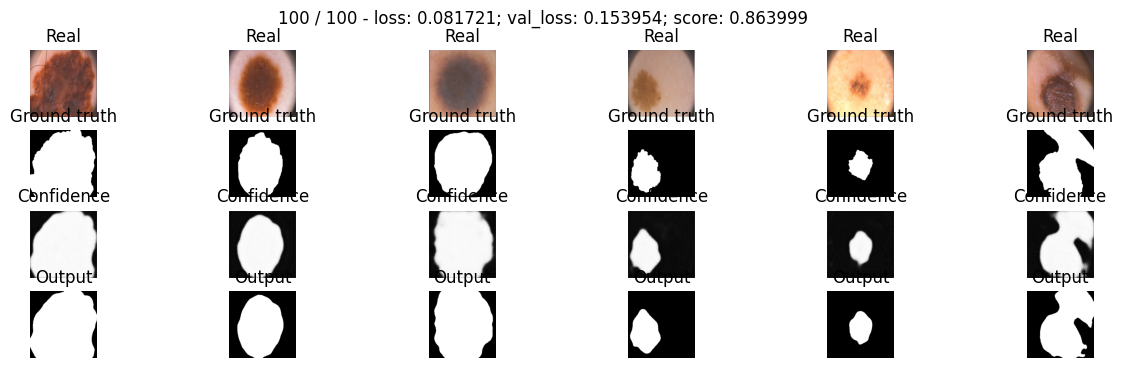

In [27]:
bce_segnet_no_augm = SegNet().to(device)
name = 'segnet_bce_no_augm'
# history_no_augm = train(bce_segnet_no_augm, bce_loss, max_epochs, data_tr, data_val, name, aug=False)
history_no_augm = train(bce_segnet_no_augm, bce_loss, max_epochs, data_tr, data_val, name)
# model_history().save(history_no_augm)

0.8325833380222321


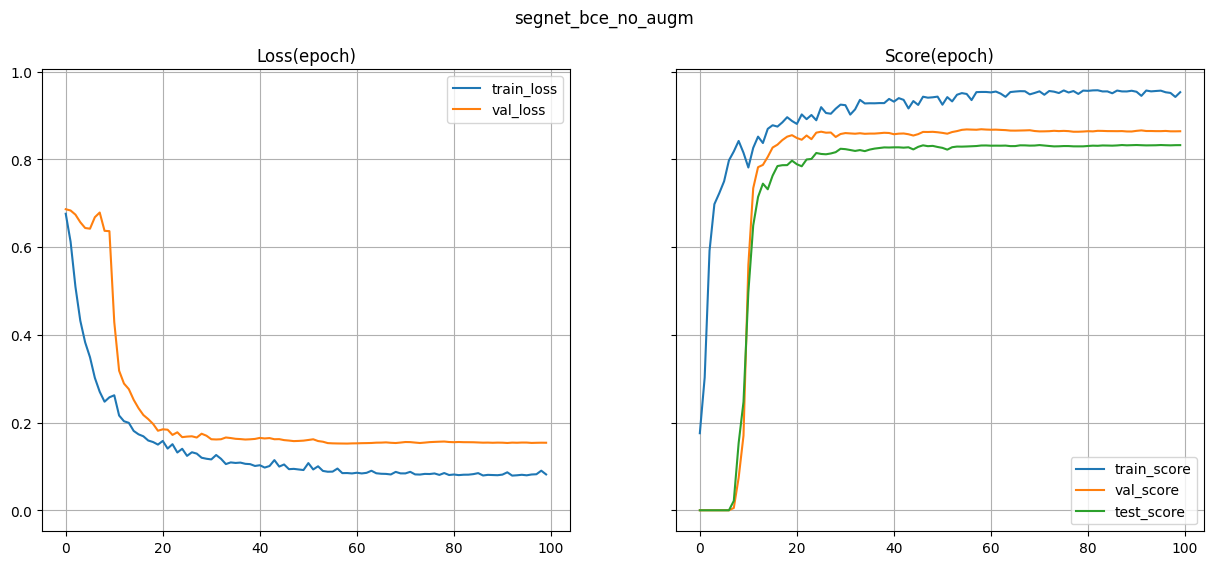

In [28]:
model_history().plot(history_no_augm)
print(max(history_no_augm['test_score']))

In [29]:
# hist = model_history().load(name)
# model_history().plot(hist)
# bce_segnet_no_augm.load_state_dict(torch.load(f'{hist["path"]}.pth')['weights'])
# print(f'Test score: {score_model(bce_segnet_no_augm, iou_pytorch, data_ts)}')

In [27]:
names = []

In [28]:

name = 'segnet_bce'
names.append(name)

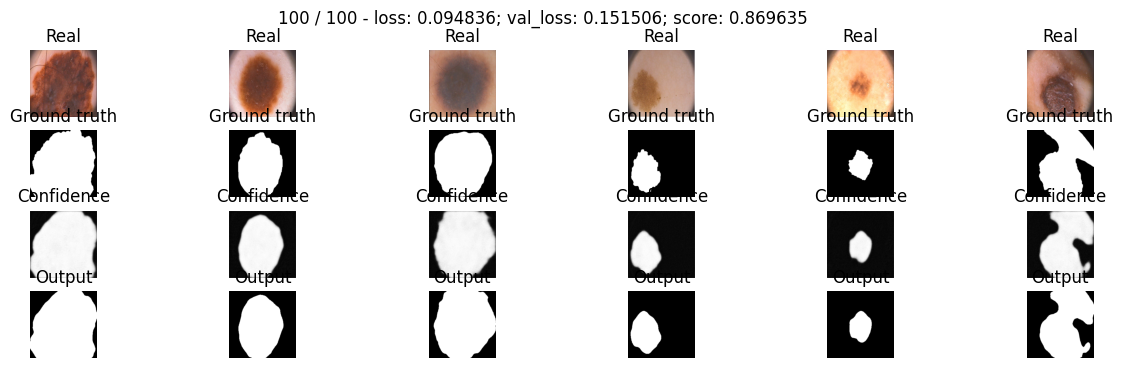

In [32]:
bce_segnet = SegNet().to(device)
# name = 'segnet_bce'
# names.append(name)
history_segnet_bce = train(bce_segnet, bce_loss, max_epochs, data_tr, data_val, name)
model_history().save(history_segnet_bce)

Test score: 0.8286714255809784


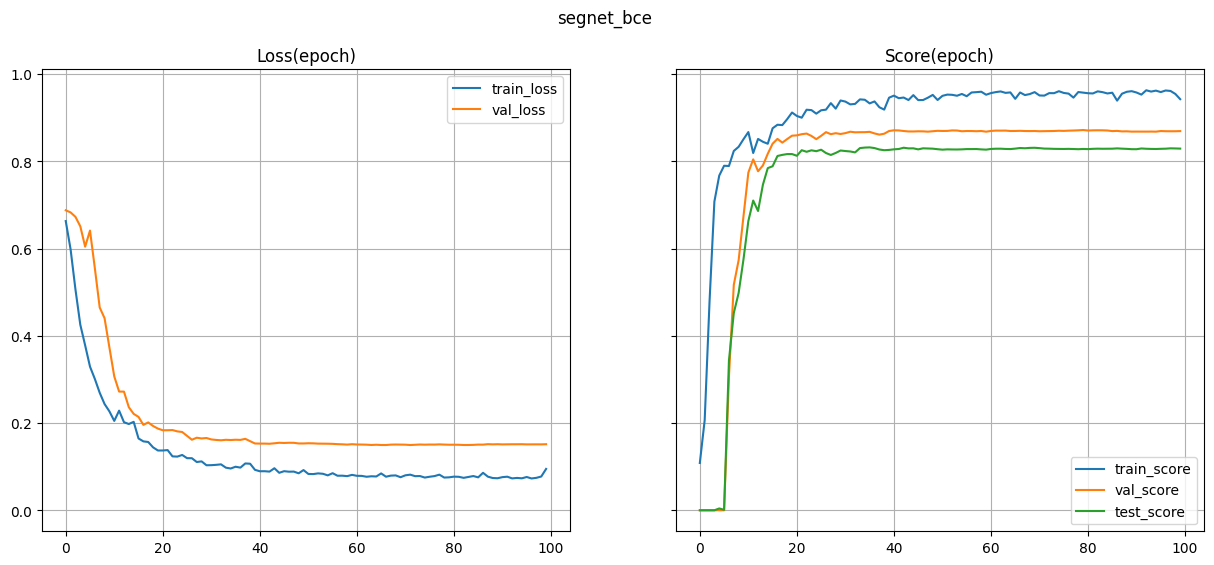

In [33]:
hist = model_history().load(name)
model_history().plot(hist)
bce_segnet.load_state_dict(torch.load(f'{hist["path"]}.pth')['weights'])
print(f'Test score: {score_model(bce_segnet, iou_pytorch, data_ts)}')

Ответьте себе на вопрос: не переобучается ли моя модель?

При обучении без аугментаций модель достаточно быстро выходит на плато, но в то же время, лосс на валидационной выборке не начинает расти. При использовании аугментаций удается добиться более высокого скора на валидационной выборке, хотя график и получается менее стабильным.
Последующее обучение будем проводить с аугментациями.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [29]:
def dice_loss(y_real, y_pred): # 25, 1, 256, 256
    smooth = 1e-8
    y_real = y_real.squeeze(1)
    y_pred = y_pred.squeeze(1)
    probs = torch.sigmoid(y_pred)
    num = (2. * y_real * probs).sum((1, 2))
    den = (y_real + probs).sum((1, 2))
    res = (num + smooth) / (den + smooth)
    return 1 - res.sum() / y_real.size(0)

Проводим тестирование:

In [30]:
name = 'segnet_dice'
names.append(name)

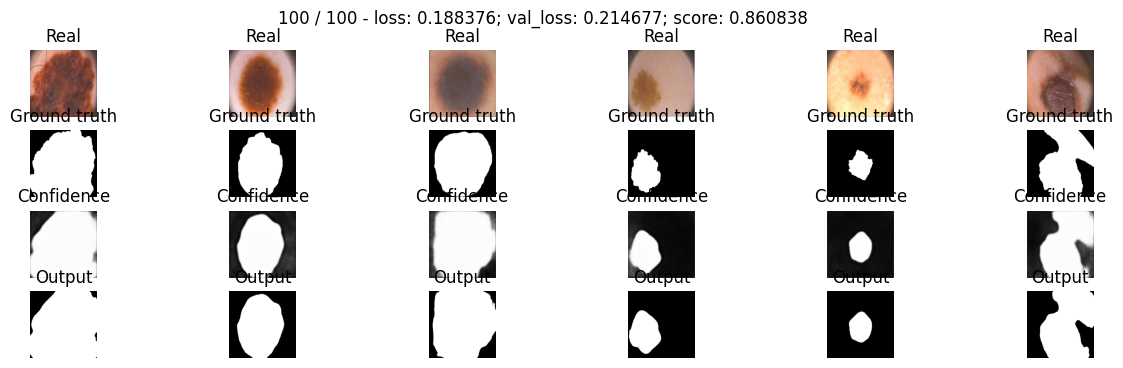

In [36]:
segnet_dice = SegNet().to(device)
segnet_dice_history = train(segnet_dice, dice_loss, max_epochs, data_tr, data_val, name)
model_history().save(segnet_dice_history)

Test score: 0.8313072621822357


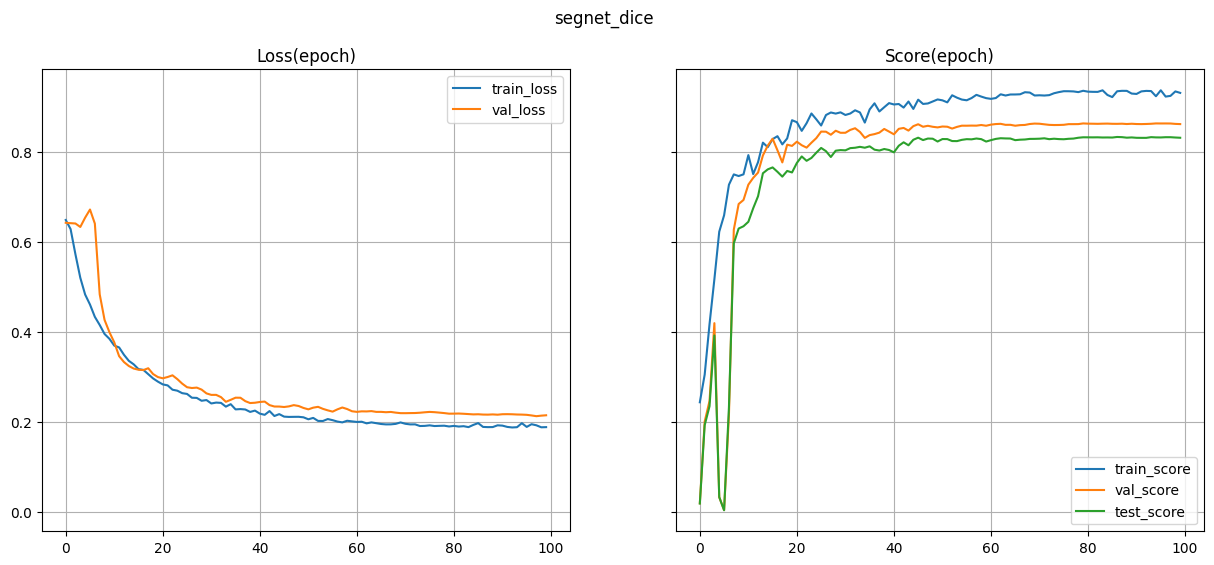

In [37]:
hist = model_history().load(name)
model_history().plot(hist)
segnet_dice.load_state_dict(torch.load(f'{hist["path"]}.pth')['weights'])
print(f'Test score: {score_model(segnet_dice, iou_pytorch, data_ts)}')

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [31]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma=2, alpha=0.25):  # дефолтные значения рекомендованы авторами статьи
    probs =  torch.sigmoid(y_pred) 
    ce_loss = bce(y_real, y_pred)
    p_t = probs * y_real + (1 - probs) * (1 - y_real)
    focal_loss = ce_loss * torch.pow(1 - p_t, gamma)
    if alpha >= 0:
        focal_loss *= alpha * y_real + (1 - alpha) * (1 - y_real)
    return focal_loss.mean()

In [32]:
name = 'segnet_focal'
names.append(name)

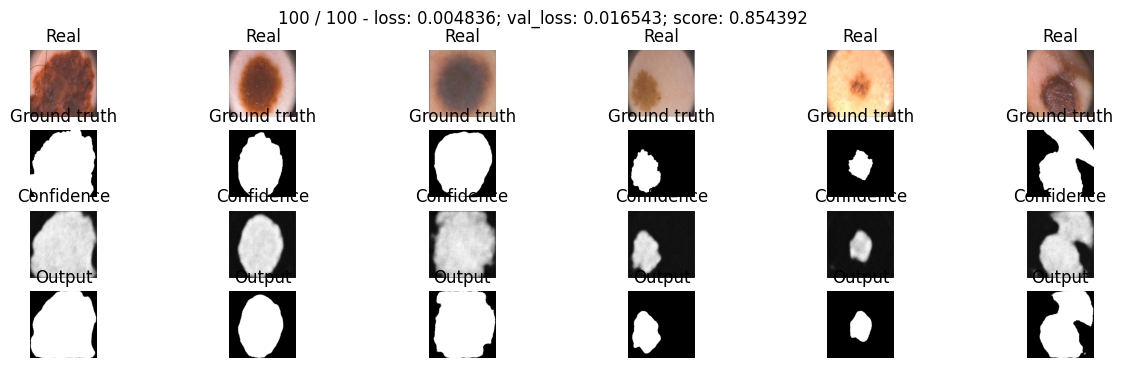

In [40]:
segnet_focal = SegNet().to(device)
segnet_focal_history = train(segnet_focal, focal_loss, max_epochs, data_tr, data_val, name)
model_history().save(segnet_focal_history)

Test score: 0.8053833842277527


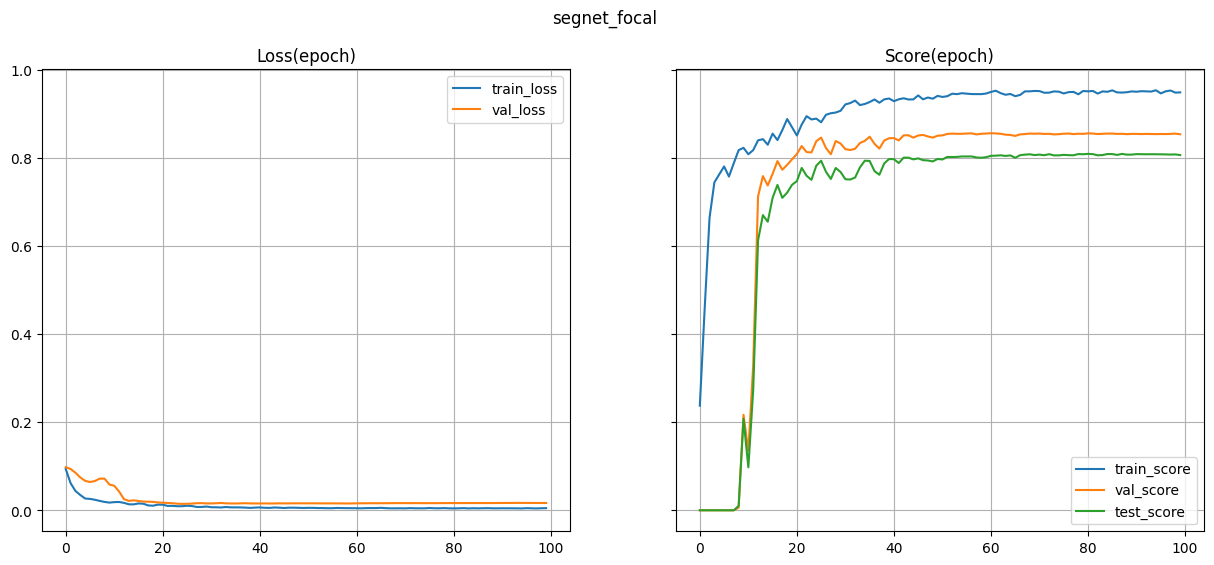

In [41]:
hist = model_history().load(name)
model_history().plot(hist)
segnet_focal.load_state_dict(torch.load(f'{hist["path"]}.pth')['weights'])
print(f'Test score: {score_model(segnet_focal, iou_pytorch, data_ts)}')

Как видно, на представленном датасете, функции потерь дают более плохой результат. Это возможно, также связанно с небольшим объемом данных и архитектурой сети.

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

**Boundary loss for highly unbalanced segmentation**
у авторов статьи есть репо на гите, посмотрим код там и воспроизведем у себя.

https://github.com/LIVIAETS/boundary-loss

https://github.com/LIVIAETS/boundary-loss/blob/master/losses.py#L76

In [33]:
def dice_boundary_loss(y_real, y_pred, alpha=0.01):
    y_real = y_real.squeeze(1)
    y_pred = y_pred.squeeze(1)
    probs = torch.sigmoid(y_pred)
    preds = probs > 0.5
    
    # computing the distance map
    foreground_map = - eucl_distance(y_real.cpu())
    background_map = eucl_distance((1 - y_real).cpu())
    dist_map = torch.tensor(background_map + foreground_map).to(device)
    
    # boundary part
    boundary_loss = ((dist_map * preds).sum((1, 2)) / (256*256)).mean()
    # boundary_loss = ((dist_map * preds).sum((1, 2)) / y_real.size(0)).mean()
    # boundary_loss = einsum("bwh,bwh->bwh", preds, dist_map).mean()
    # boundary_loss = (torch.einsum("bwh,bwh->b", probs, dist_map) /(256*256)).mean()
    
    # dice loss (regional part)
    smooth = 1e-8
    num = (2. * y_real * probs).sum((1, 2))
    den = (y_real + probs).sum((1, 2))
    # num = 2. * torch.einsum("bwh,bwh->b", probs, y_real)
    # den = (torch.einsum("bwh->b", probs) + torch.einsum("bwh->b", y_real))
    dice = (num + smooth) / (den + smooth)
    dice = 1 - dice.sum() / y_real.size(0)
    
    # return dice + alpha * boundary_loss
    return (1 - alpha) * dice + alpha * boundary_loss

In [34]:
name='segnet_bound'
names.append(name)

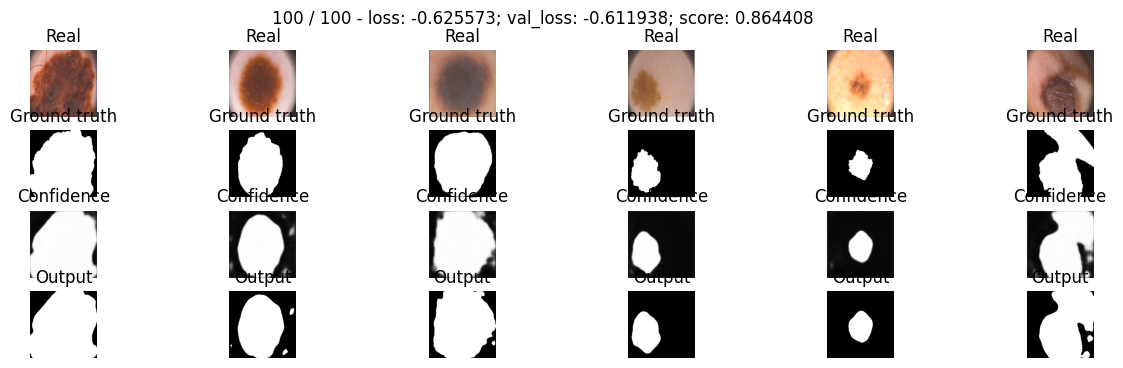

In [44]:
segnet_bound = SegNet().to(device)
segnet_bound_history = train(segnet_bound, dice_boundary_loss, max_epochs, data_tr, data_val, name, boundary=True)
model_history().save(segnet_bound_history)

Test score: 0.8255914747714996


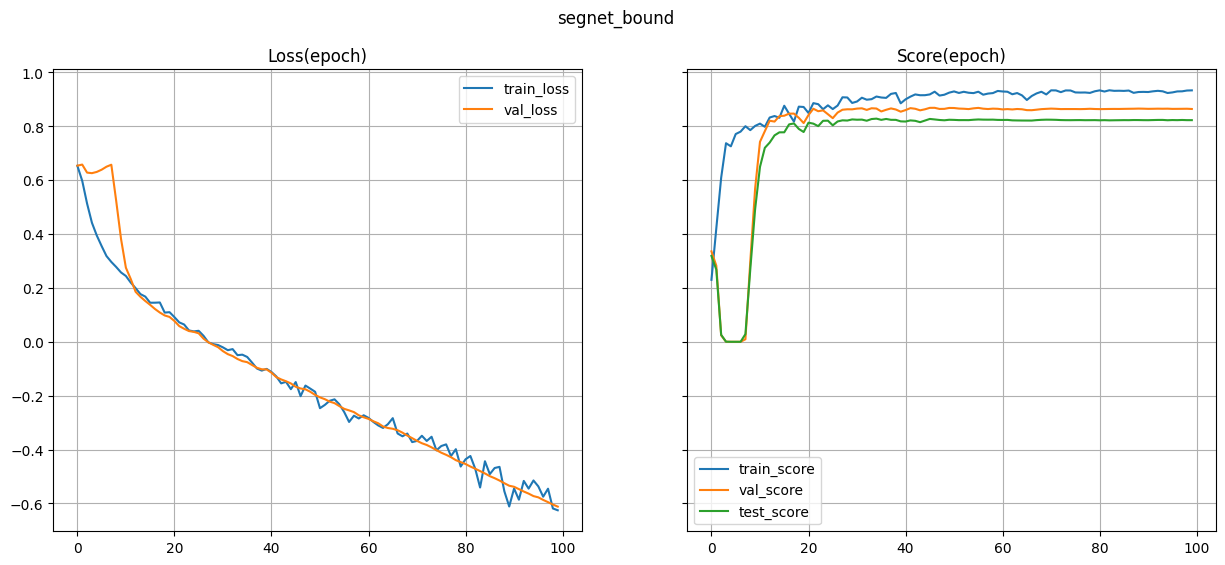

In [45]:
hist = model_history().load(name)
model_history().plot(hist)
segnet_bound.load_state_dict(torch.load(f'{hist["path"]}.pth')['weights'])
print(f'Test score: {score_model(segnet_bound, iou_pytorch, data_ts)}')

Аналогично предыдущему случаю. Ожидается более качественные результаты на Unet.

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

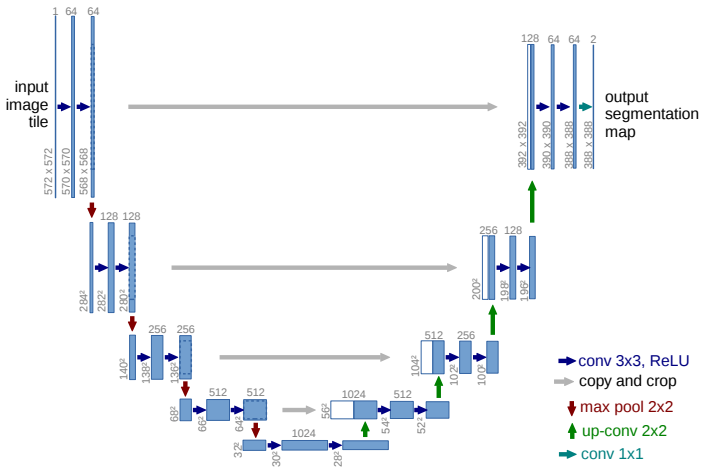

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [35]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool0 = nn.MaxPool2d(2, 2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool1 = nn.MaxPool2d(2, 2)  # 128 -> 64 
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool2 = nn.MaxPool2d(2, 2)  # 64 -> 32 
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )
        self.pool3 = nn.MaxPool2d(2, 2)  # 32 -> 16 

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            ) 

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            ) 
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            ) 
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 1)
            )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)
        
        # bottleneck
        b = self.upsample0(self.bottleneck_conv(p3))
        
        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat([b, e3], dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat([d0, e2], dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat([d1, e1], dim=1)))
        d3 = self.dec_conv3(torch.cat([d2, e0], dim=1))  # no activation
        return d3

In [36]:
name = 'unet_bce'
names.append(name)

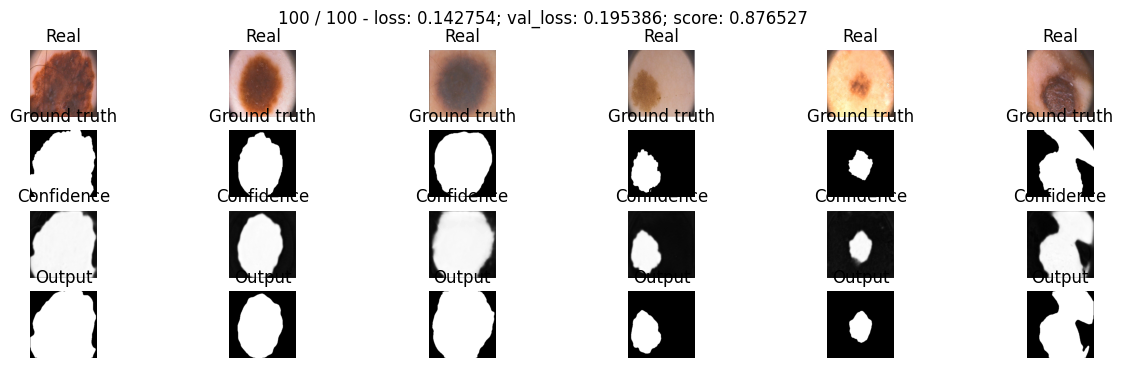

In [48]:
unet_bce = UNet().to(device)
history_unet_bce = train(unet_bce, bce_loss, max_epochs, data_tr, data_val, name)
model_history().save(history_unet_bce)

Test score: 0.8357118368148804


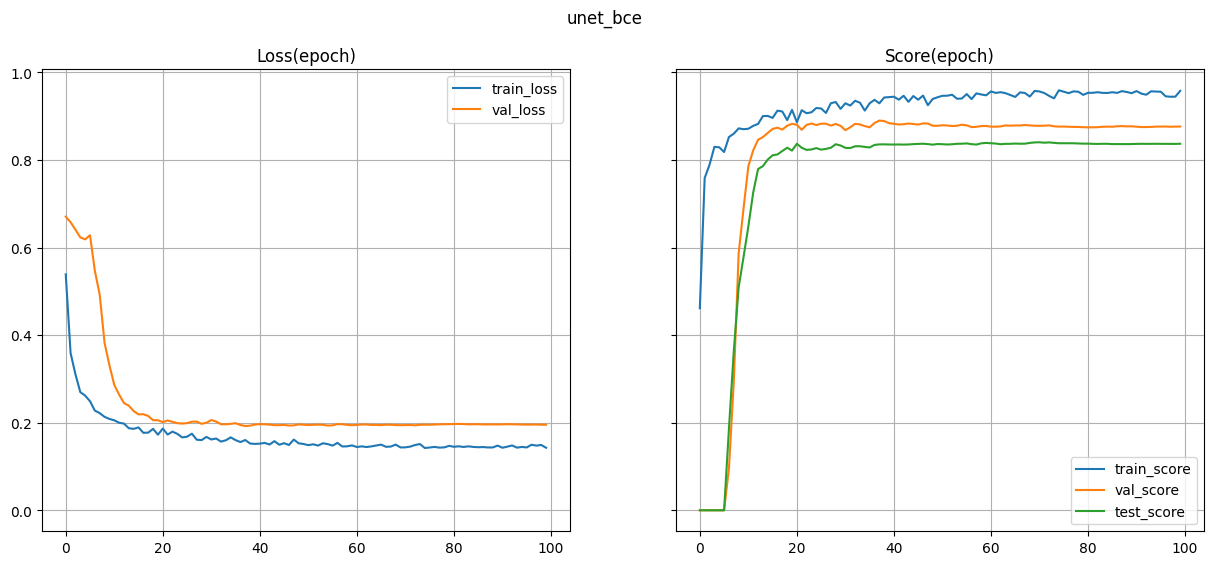

In [49]:
hist = model_history().load(name)
model_history().plot(hist)
unet_bce.load_state_dict(torch.load(f'{hist["path"]}.pth')['weights'])
print(f'Test score: {score_model(unet_bce, iou_pytorch, data_ts)}')

In [37]:
name = 'unet_dice'
names.append(name)

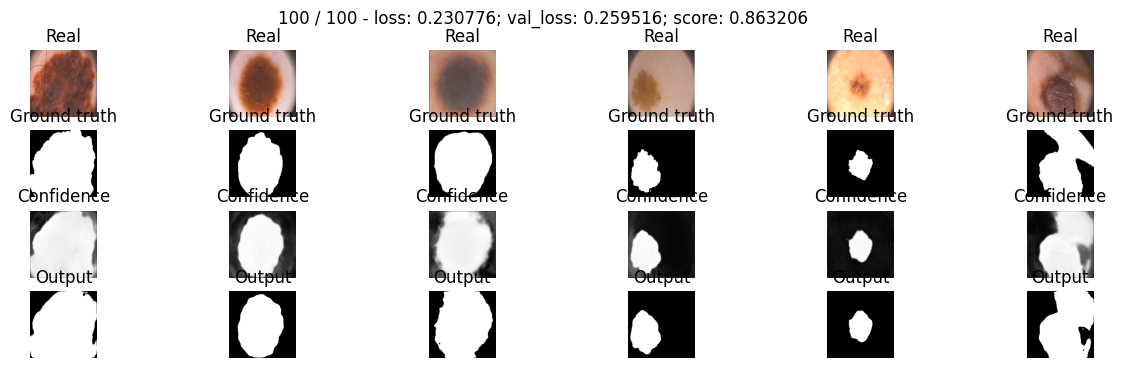

In [51]:
unet_dice = UNet().to(device)
history_unet_dice = train(unet_dice, dice_loss, max_epochs, data_tr, data_val, name)
model_history().save(history_unet_dice)

Test score: 0.8390688598155975


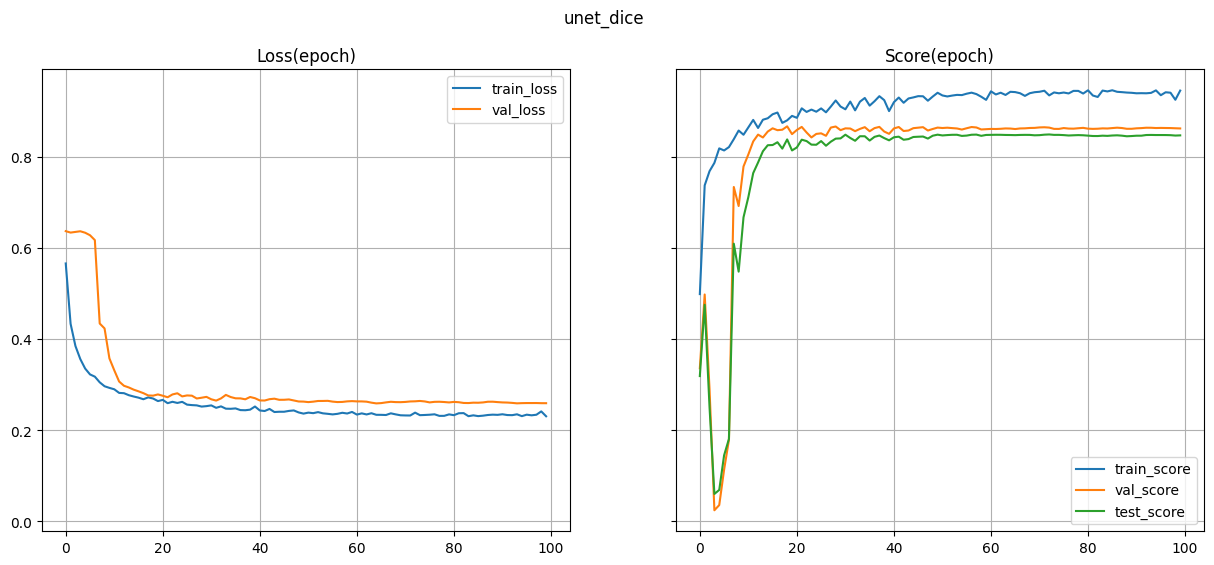

In [52]:
hist = model_history().load(name)
model_history().plot(hist)
unet_dice.load_state_dict(torch.load(f'{hist["path"]}.pth')['weights'])
print(f'Test score: {score_model(unet_dice, iou_pytorch, data_ts)}')

In [38]:
name = 'unet_focal'
names.append(name)

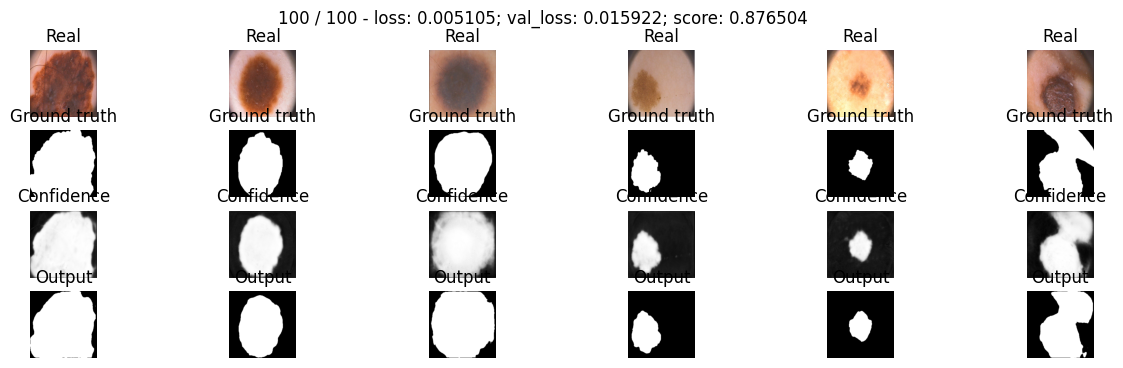

In [54]:
unet_focal = UNet().to(device)
history_unet_focal = train(unet_focal, focal_loss, max_epochs, data_tr, data_val, name)
model_history().save(history_unet_focal)

Test score: 0.8324326872825623


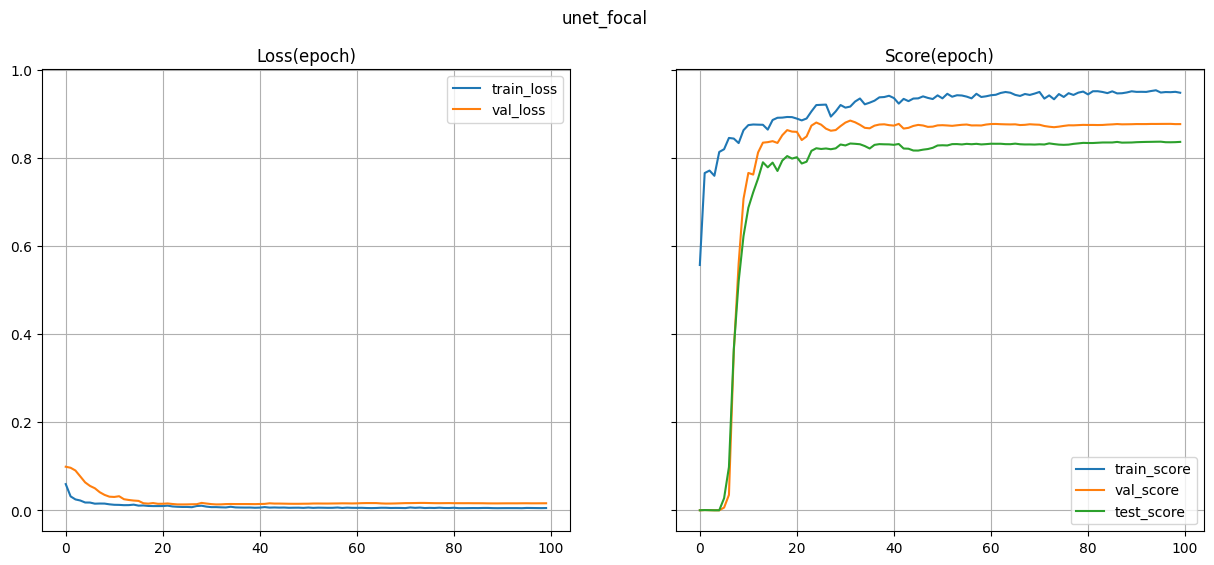

In [55]:
hist = model_history().load(name)
model_history().plot(hist)
unet_focal.load_state_dict(torch.load(f'{hist["path"]}.pth')['weights'])
print(f'Test score: {score_model(unet_focal, iou_pytorch, data_ts)}')

In [39]:
name = 'unet_bound'
names.append(name)

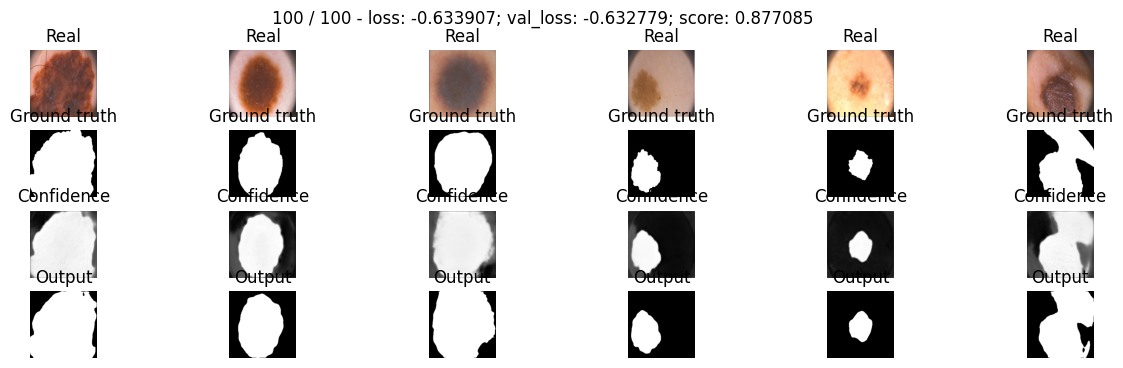

In [57]:
unet_bound = UNet().to(device)
history_unet_bound = train(unet_bound, dice_boundary_loss, max_epochs, data_tr, data_val, name, boundary=True)
model_history().save(history_unet_bound)

Test score: 0.8275521695613861


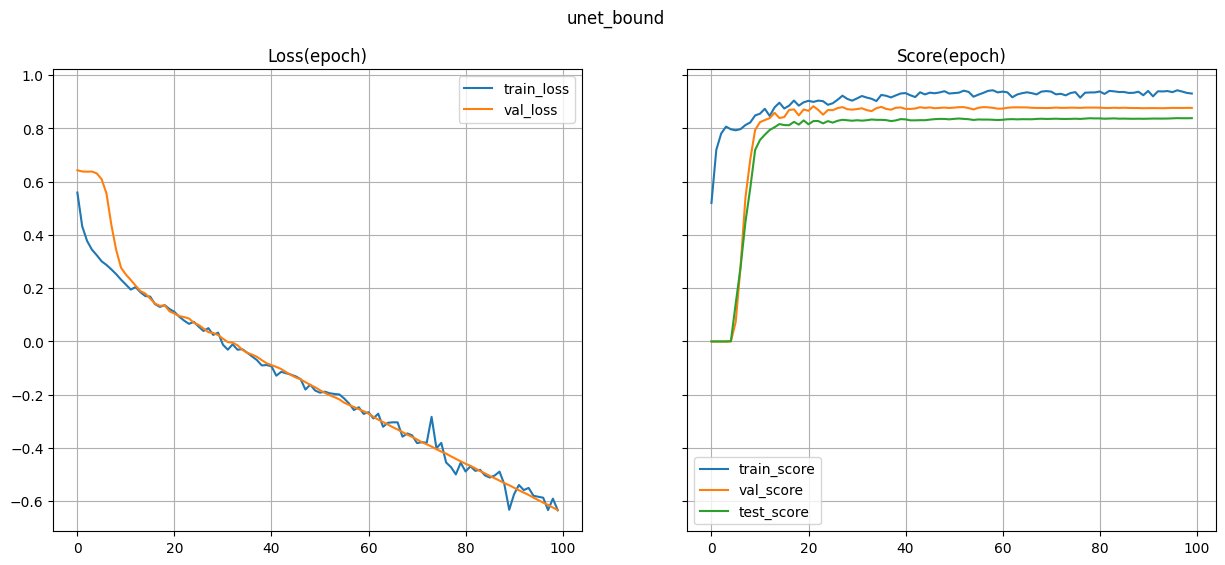

In [58]:
hist = model_history().load(name)
model_history().plot(hist)
unet_bound.load_state_dict(torch.load(f'{hist["path"]}.pth')['weights'])
print(f'Test score: {score_model(unet_bound, iou_pytorch, data_ts)}')

Результаты похожи на SegNet - наибольший результат получен с BCE Loss. Для Unet максимальное значение выше, чем для SegNet. Неплохо подошел так же Boundary Loss.

Напишем еще одну версию Unet, использующую mirror padding - отражение изображения по границе, описывалось в лекуции. Отнаследуем новый класс от осандартного Unet.

In [40]:
# overlap-tile
class UNet_overlap(UNet):
    def __init__(self):
        super(UNet_overlap, self).__init__()
        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, 3),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, 3),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )       

    def mirror_pad(self, x):
        """
        increases h and w by 2 by mirroring edge pixels
        """
        top = torch.flip(x[:, :, :2, :], [0, 1, 2])
        x = torch.cat([top, x], dim=2)
        
        bottom = torch.flip(x[:, :, -2:, :], [0, 1, 2])
        x = torch.cat([x, bottom], dim=2)
        
        left = torch.flip(x[:, :, :, :2], [0, 1, 3])
        x = torch.cat([left, x], dim=3)
        
        right = torch.flip(x[:, :, :, -2:], [0, 1, 3])
        x = torch.cat([x, right], dim=3)
        return x  

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(self.mirror_pad(x))
        p0 = self.pool0(e0)
        e1 = self.enc_conv1(self.mirror_pad(p0))
        p1 = self.pool1(e1)
        e2 = self.enc_conv2(self.mirror_pad(p1))
        p2 = self.pool2(e2)
        e3 = self.enc_conv3(self.mirror_pad(p2))
        p3 = self.pool3(e3)
        
        # bottleneck
        b = self.upsample0(self.bottleneck_conv(self.mirror_pad(p3)))
        
        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat([b, e3], dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat([d0, e2], dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat([d1, e1], dim=1)))
        d3 = self.dec_conv3(torch.cat([d2, e0], dim=1))  # no activation
        return d3

In [41]:
name = 'unet_overlap_bce'
names.append(name)

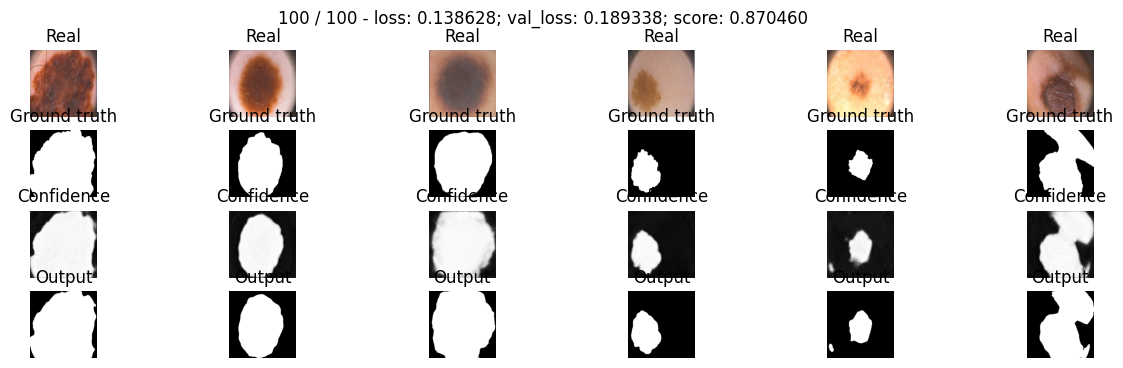

In [61]:
unet_op_bce = UNet_overlap().to(device)
history_unet_op_bce = train(unet_op_bce, bce_loss, max_epochs, data_tr, data_val, name)
model_history().save(history_unet_op_bce)

Test score: 0.8546475768089294


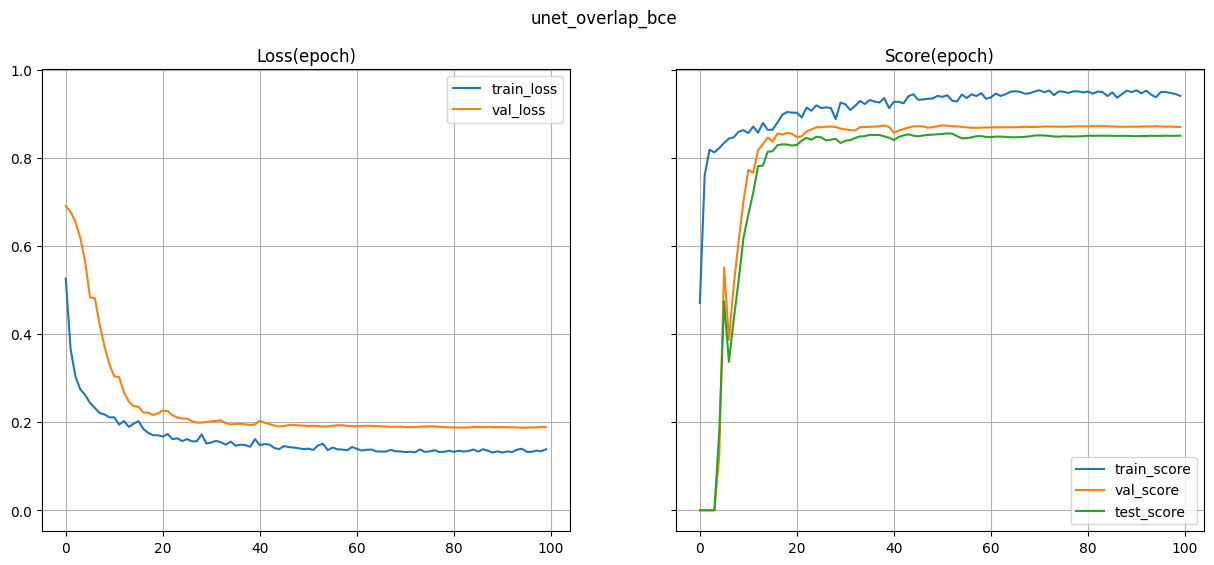

In [62]:
hist = model_history().load(name)
model_history().plot(hist)
unet_op_bce.load_state_dict(torch.load(f'{hist["path"]}.pth')['weights'])
print(f'Test score: {score_model(unet_op_bce, iou_pytorch, data_ts)}')

In [42]:
name = 'unet_overlap_dice'
names.append(name)

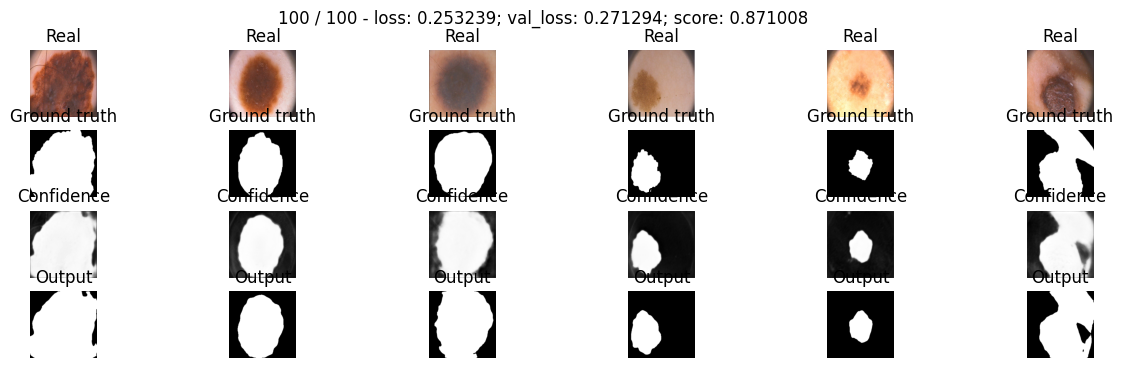

In [64]:
unet_op_dice = UNet_overlap().to(device)
history_unet_op_dice = train(unet_op_dice, dice_loss, max_epochs, data_tr, data_val, name)
model_history().save(history_unet_op_dice)

Test score: 0.8285046219825745


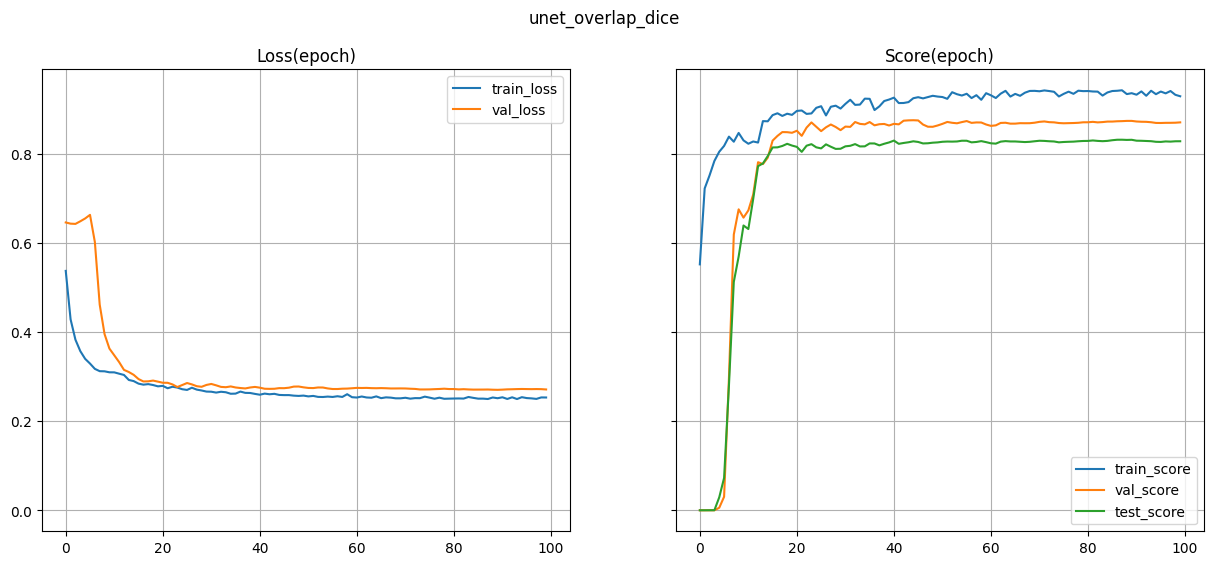

In [65]:
hist = model_history().load(name)
model_history().plot(hist)
unet_op_dice.load_state_dict(torch.load(f'{hist["path"]}.pth')['weights'])
print(f'Test score: {score_model(unet_op_dice, iou_pytorch, data_ts)}')

In [43]:
name = 'unet_overlap_focal'
names.append(name)

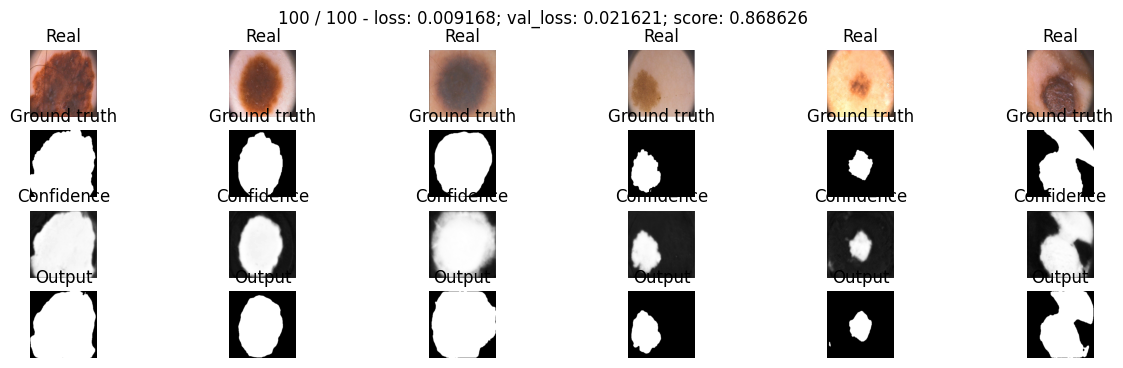

In [67]:
unet_op_focal = UNet_overlap().to(device)
history_unet_op_focal = train(unet_op_focal, focal_loss, max_epochs, data_tr, data_val, name)
model_history().save(history_unet_op_focal)

Test score: 0.8242595195770264


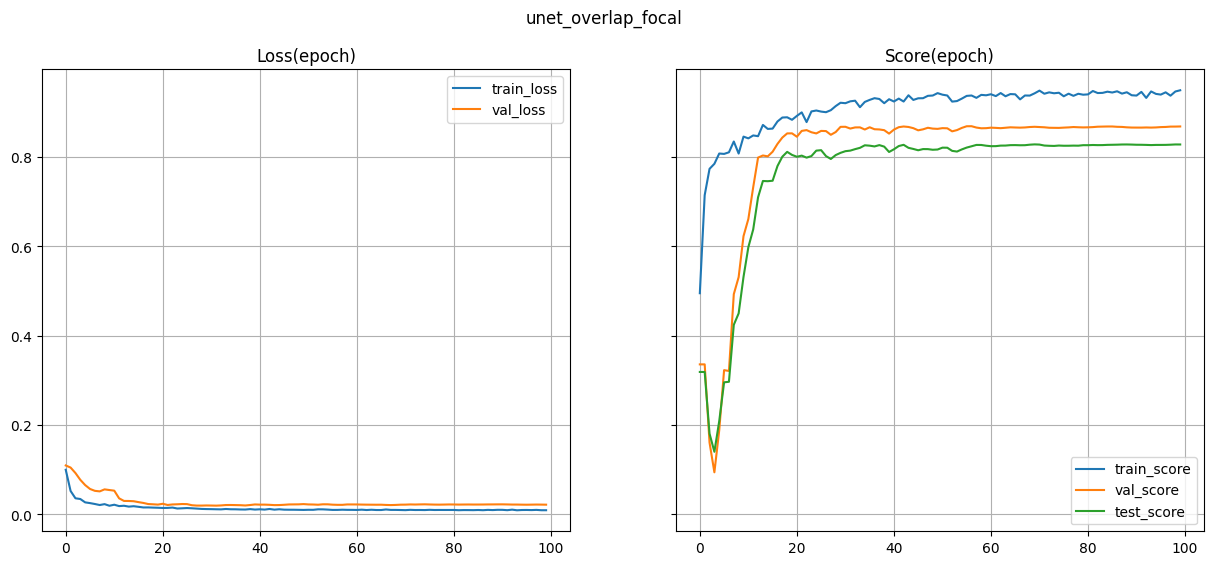

In [68]:
hist = model_history().load(name)
model_history().plot(hist)
unet_op_focal.load_state_dict(torch.load(f'{hist["path"]}.pth')['weights'])
print(f'Test score: {score_model(unet_op_focal, iou_pytorch, data_ts)}')

In [44]:
name = 'unet_overlap_bound'
names.append(name)

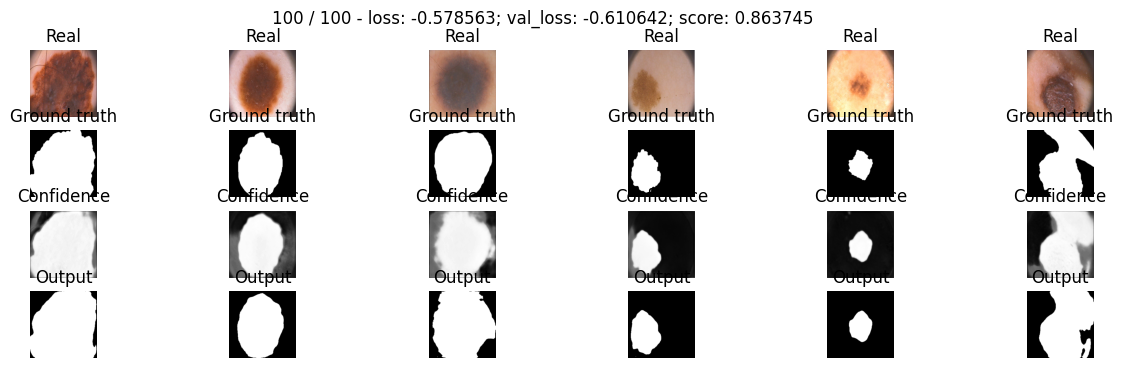

In [70]:
unet_op_bound = UNet_overlap().to(device)
history_unet_op_bound = train(unet_op_bound, dice_boundary_loss, max_epochs, data_tr, data_val, name, boundary=True)
model_history().save(history_unet_op_bound)

Test score: 0.8383786082267761


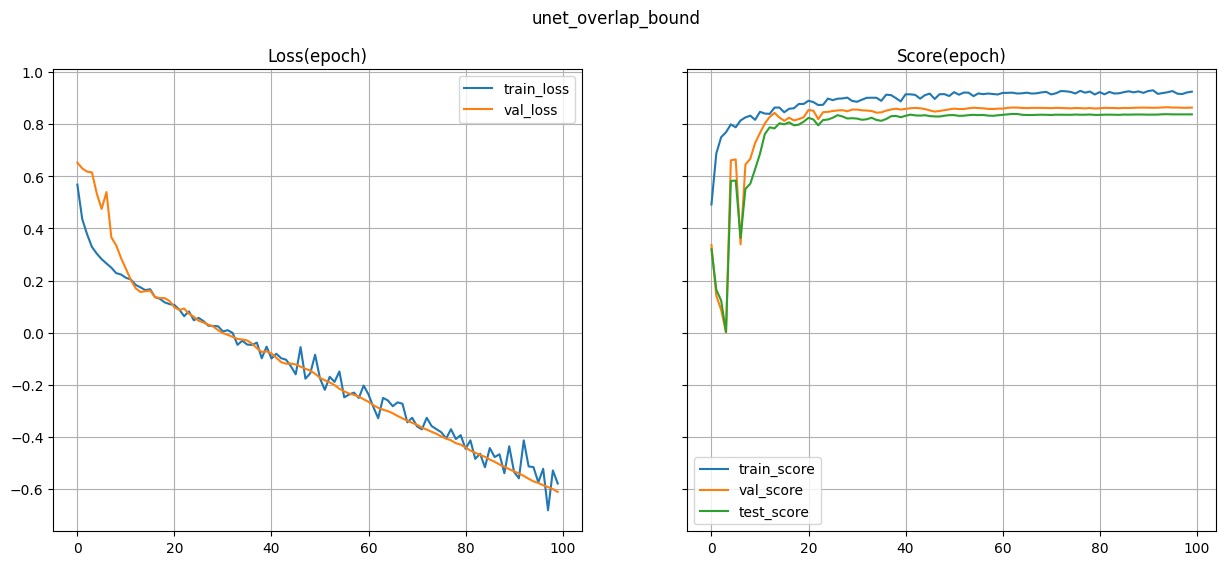

In [71]:
hist = model_history().load(name)
model_history().plot(hist)
unet_op_bound.load_state_dict(torch.load(f'{hist["path"]}.pth')['weights'])
print(f'Test score: {score_model(unet_op_bound, iou_pytorch, data_ts)}')

Добавление зеркальных границ позволило улучшить скор для ряда лоссов.

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [45]:
class UNet2(UNet):
    def __init__(self):
        super(UNet2, self).__init__()
        # encoder
        self.pool0 = nn.Conv2d(64, 64, 2, 2)  # 256 -> 128
        self.pool1 = nn.Conv2d(128, 128, 2, 2)  # 128 -> 64 
        self.pool2 = nn.Conv2d(256, 256, 2, 2)  # 64 -> 32 
        self.pool3 = nn.Conv2d(512, 512, 2, 2)  # 32 -> 16 
        # bottleneck
        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(512, 512, 2, 2)  # 16 -> 32
        self.upsample1 = nn.ConvTranspose2d(256, 256, 2, 2) # 32 -> 64
        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, 2)  # 64 -> 128
        self.upsample3 = nn.ConvTranspose2d(64, 64, 2, 2)  # 128 -> 256

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)
        
        # bottleneck
        b = self.upsample0(self.bottleneck_conv(p3))
        
        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat([b, e3], dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat([d0, e2], dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat([d1, e1], dim=1)))
        d3 = self.dec_conv3(torch.cat([d2, e0], dim=1))  # no activation
        return d3

In [46]:
name = 'unet2_bce'
names.append(name)

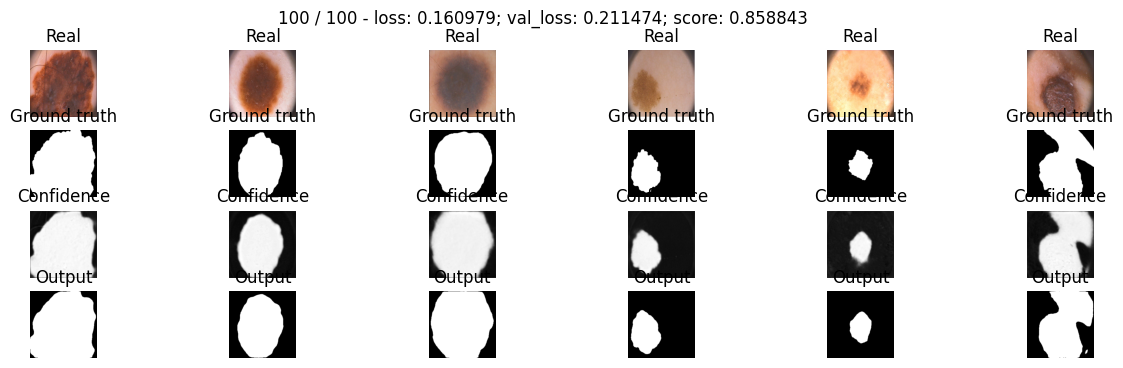

In [47]:
unet2_bce = UNet2().to(device)
history_unet2_bce = train(unet2_bce, bce_loss, max_epochs, data_tr, data_val, name)
model_history().save(history_unet2_bce)

Test score: 0.828618049621582


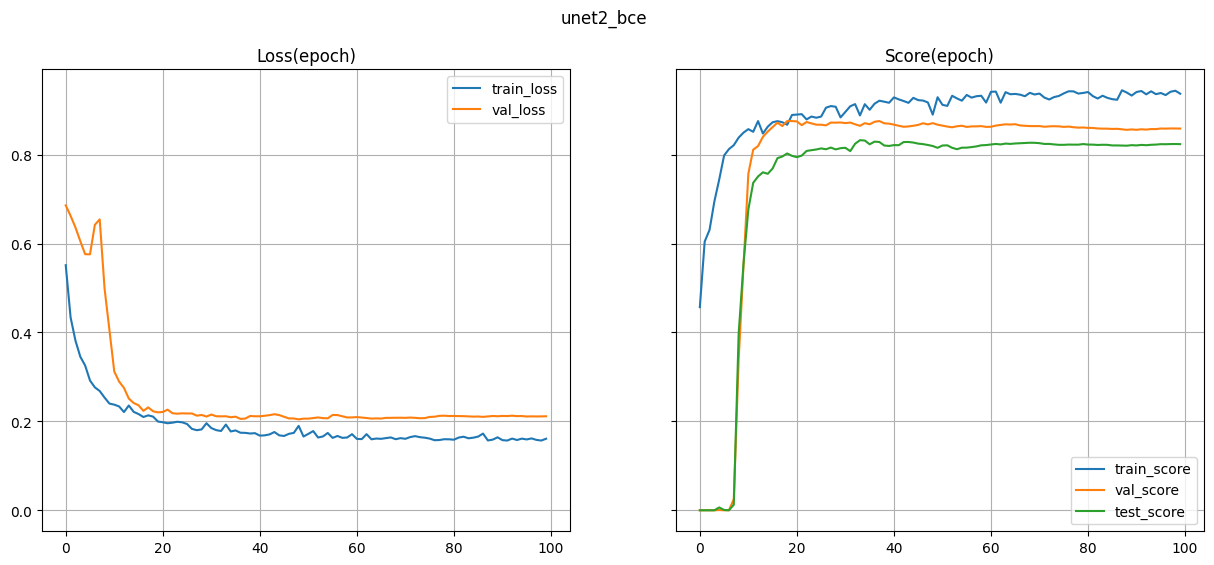

In [48]:
hist = model_history().load(name)
model_history().plot(hist)
unet2_bce.load_state_dict(torch.load(f'{hist["path"]}.pth')['weights'])
print(f'Test score: {score_model(unet2_bce, iou_pytorch, data_ts)}')

In [49]:
name = 'unet2_dice'
names.append(name)

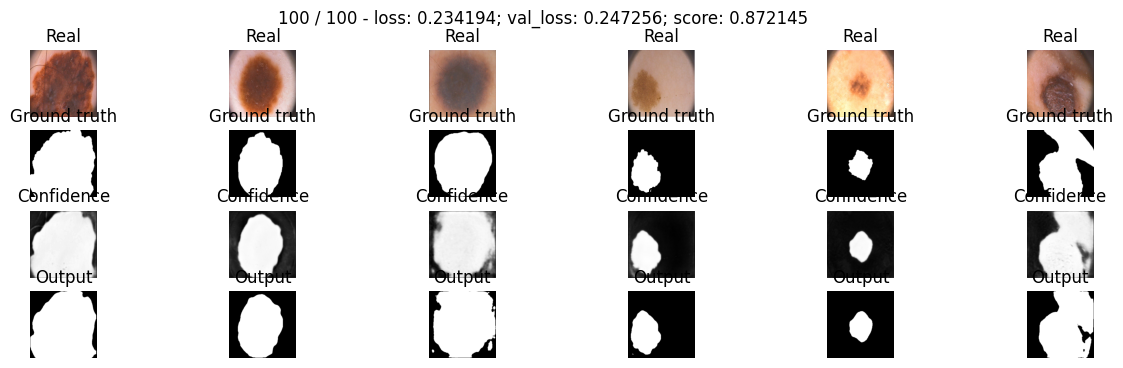

In [50]:
unet2_dice = UNet2().to(device)
history_unet2_dice = train(unet2_dice, dice_loss, max_epochs, data_tr, data_val, name)
model_history().save(history_unet2_dice)

Test score: 0.8170118927955627


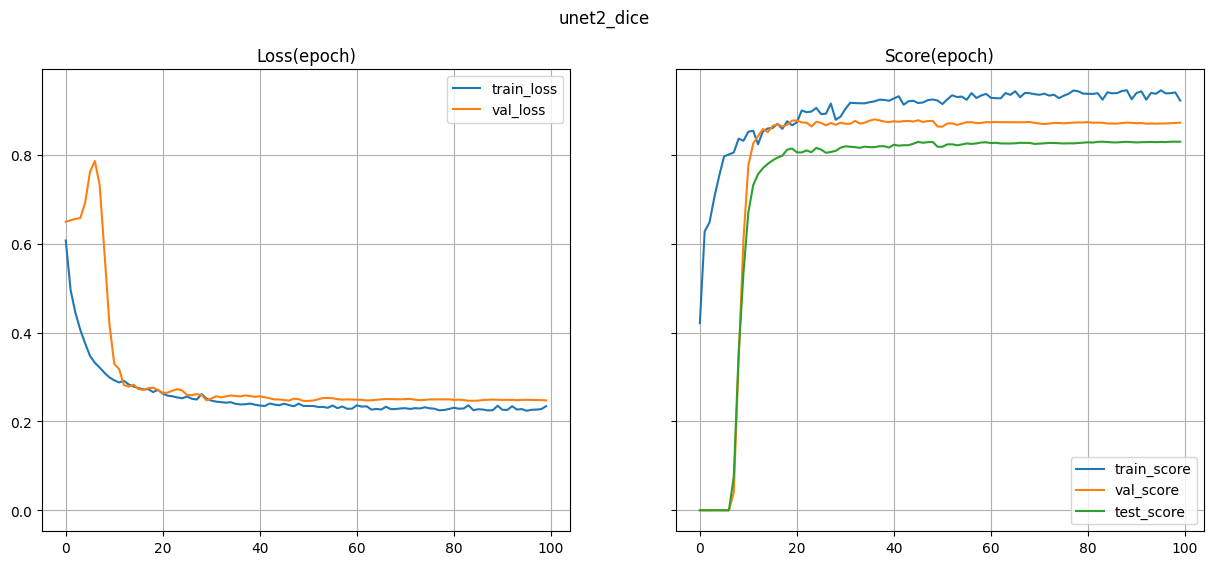

In [51]:
hist = model_history().load(name)
model_history().plot(hist)
unet2_dice.load_state_dict(torch.load(f'{hist["path"]}.pth')['weights'])
print(f'Test score: {score_model(unet2_dice, iou_pytorch, data_ts)}')

In [52]:
name = 'unet2_focal'
names.append(name)

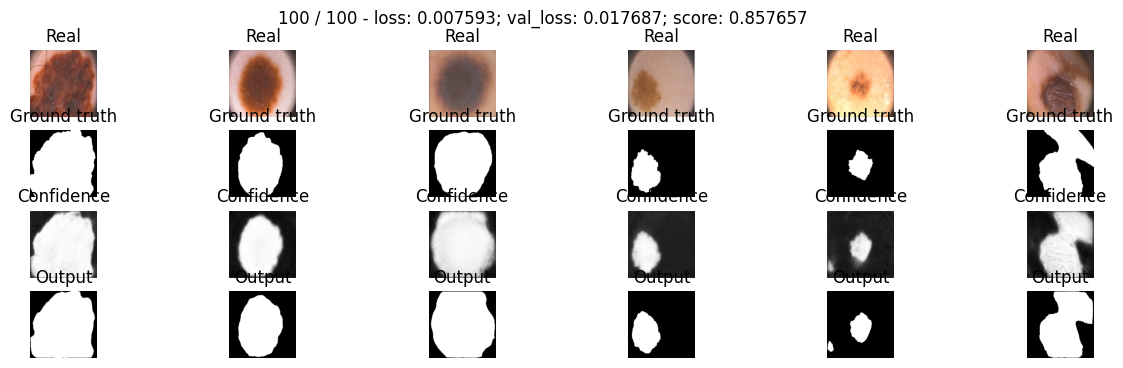

In [53]:
unet2_focal = UNet2().to(device)
history_unet2_focal = train(unet2_focal, focal_loss, max_epochs, data_tr, data_val, name)
model_history().save(history_unet2_focal)

Test score: 0.8222053349018097


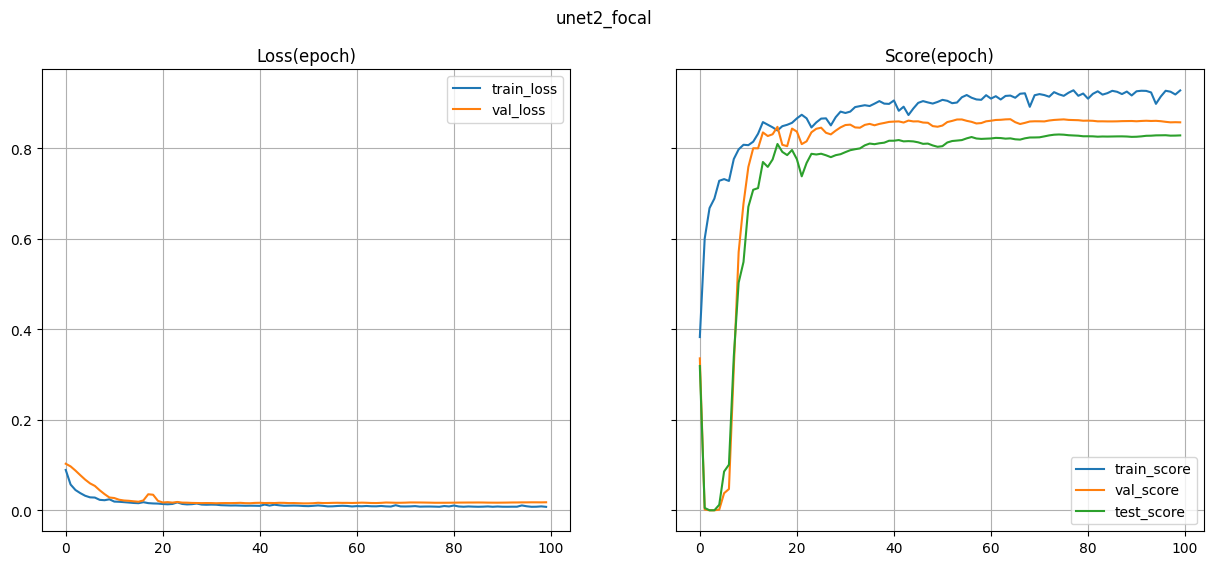

In [54]:
hist = model_history().load(name)
model_history().plot(hist)
unet2_focal.load_state_dict(torch.load(f'{hist["path"]}.pth')['weights'])
print(f'Test score: {score_model(unet2_focal, iou_pytorch, data_ts)}')

In [55]:
name = 'unet2_bound'
names.append(name)

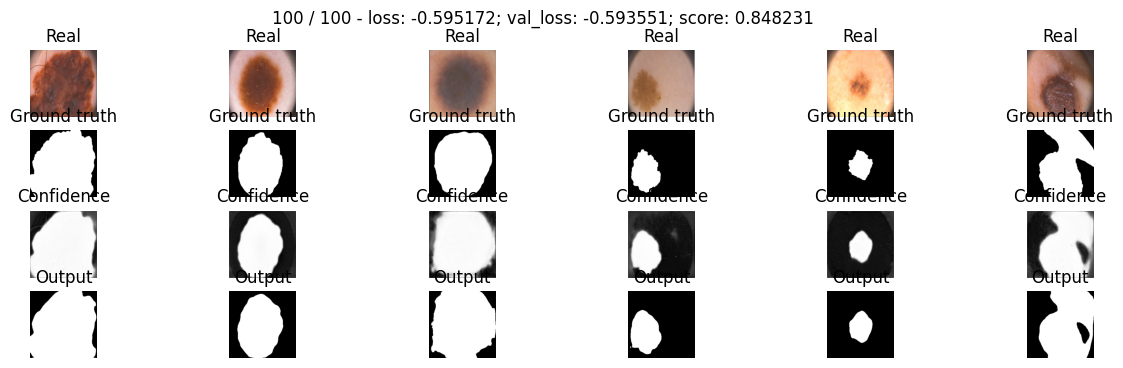

In [56]:
unet2_bound = UNet2().to(device)
history_unet2_bound = train(unet2_bound, dice_boundary_loss, max_epochs, data_tr, data_val, name, boundary=True)
model_history().save(history_unet2_bound)

Test score: 0.8093458712100983


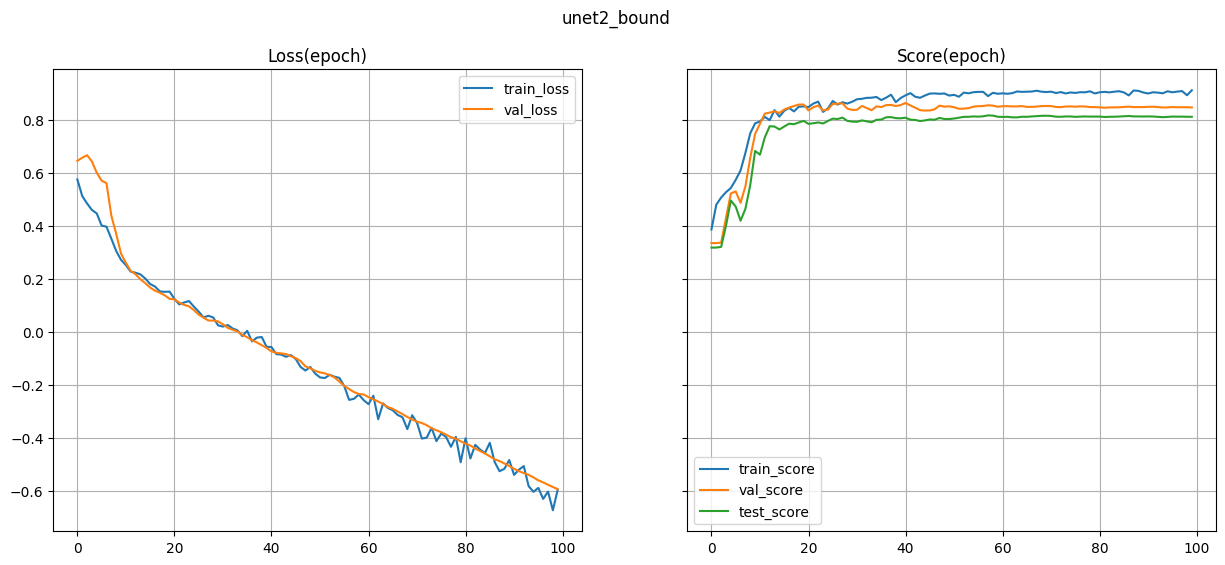

In [57]:
hist = model_history().load(name)
model_history().plot(hist)
unet2_bound.load_state_dict(torch.load(f'{hist["path"]}.pth')['weights'])
print(f'Test score: {score_model(unet2_bound, iou_pytorch, data_ts)}')

Сделайте вывод, какая из моделей лучше

Лучше всего себя проявила комбинация Unet с BCE Loss. Но на таком маленьком датасете сложно сделать однозначные выводы, ожидается, что при увеличении обучающей выборки хотя бы в 2 раза (до 200 картинок), качество могло бы заметно измениться.

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

Как и было описано выше, наибольшее значение на результат оказала используемая функция потерь. Лучшей оказалась BCE Loss. Несмотря на то, в абсолютных значениях она оказывается выше других, результаты на тесте оказываются наибольшими именно с ней.

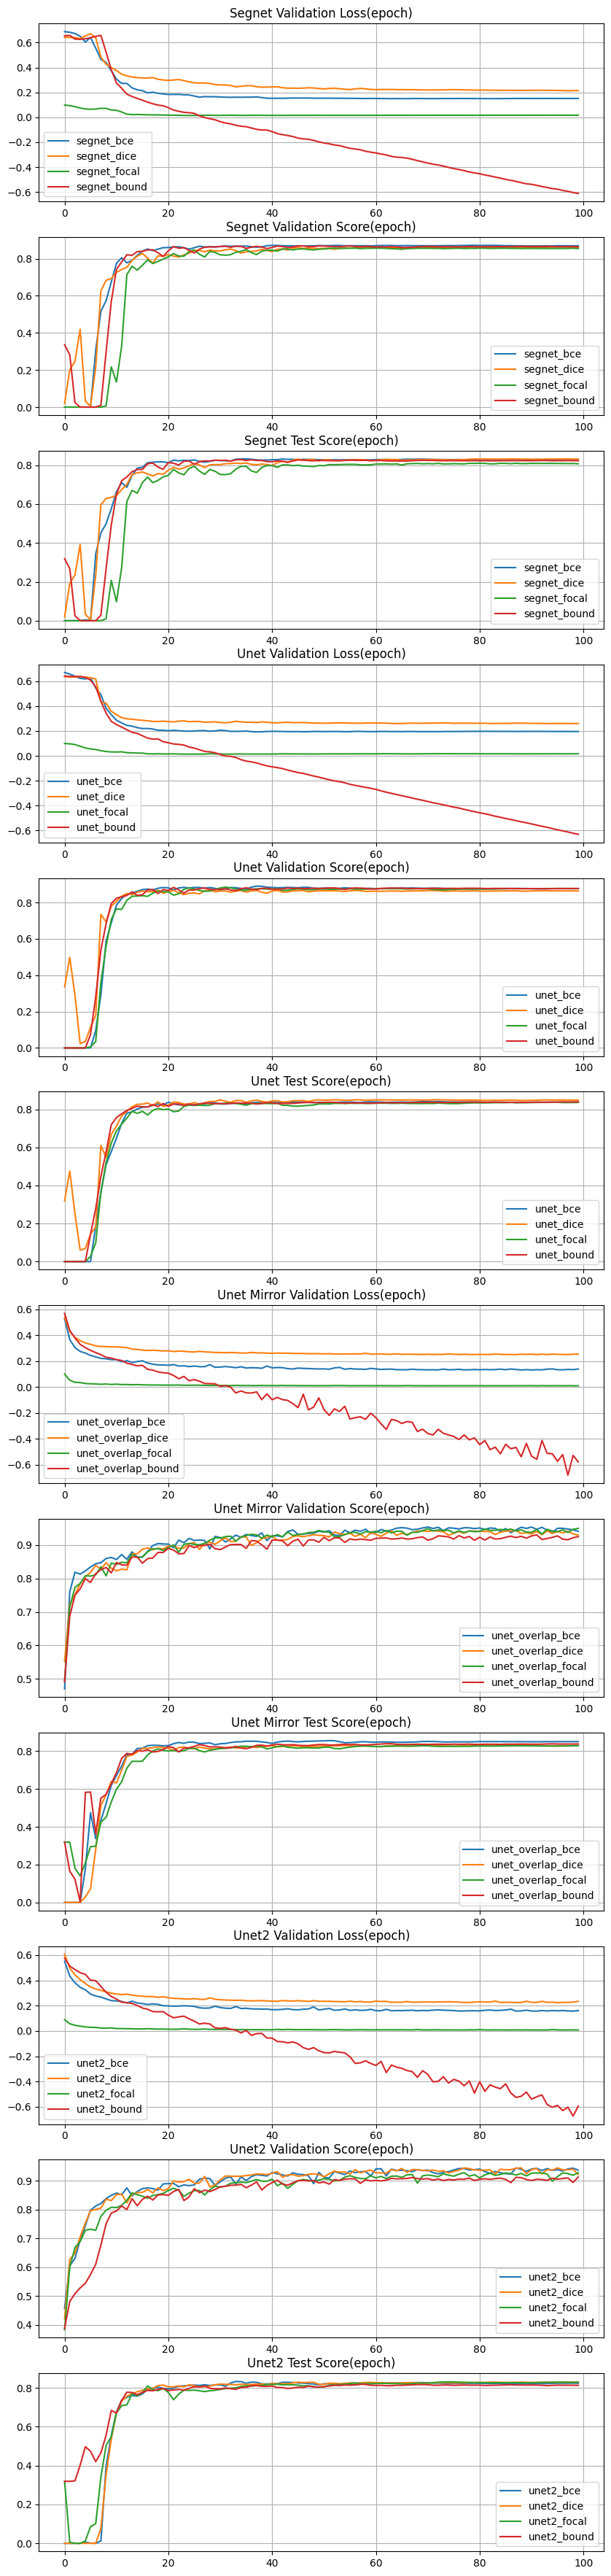

In [58]:
model_history().plot_summary(names)

Отделим модели с BCE. В таком сравнении, наибольший результат достигнут у SegNet.

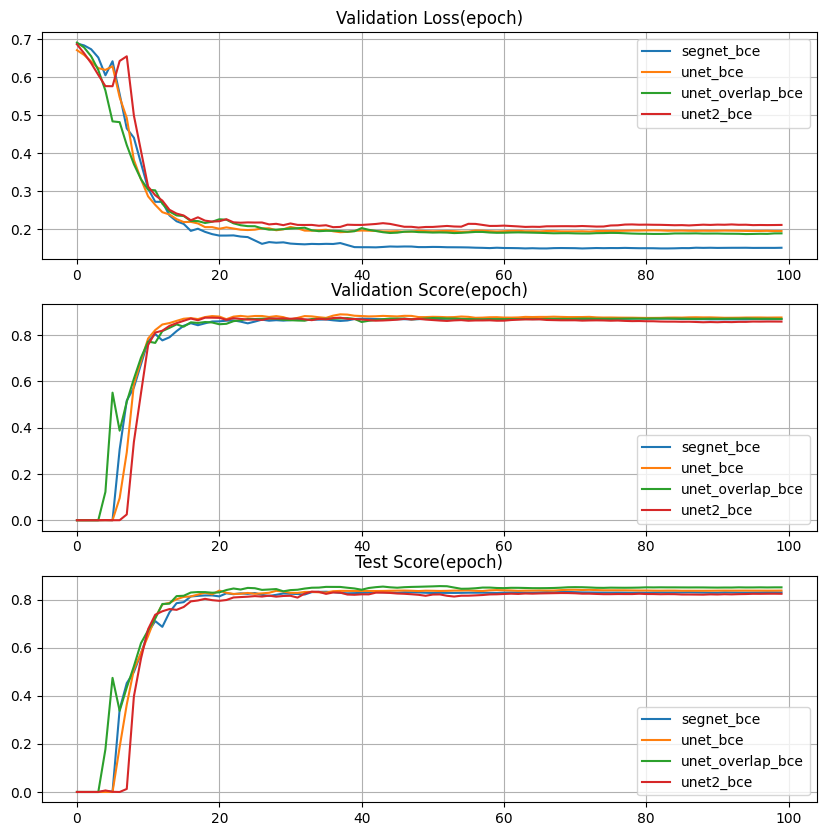

In [59]:
model_history().plot_summary_bce(names)

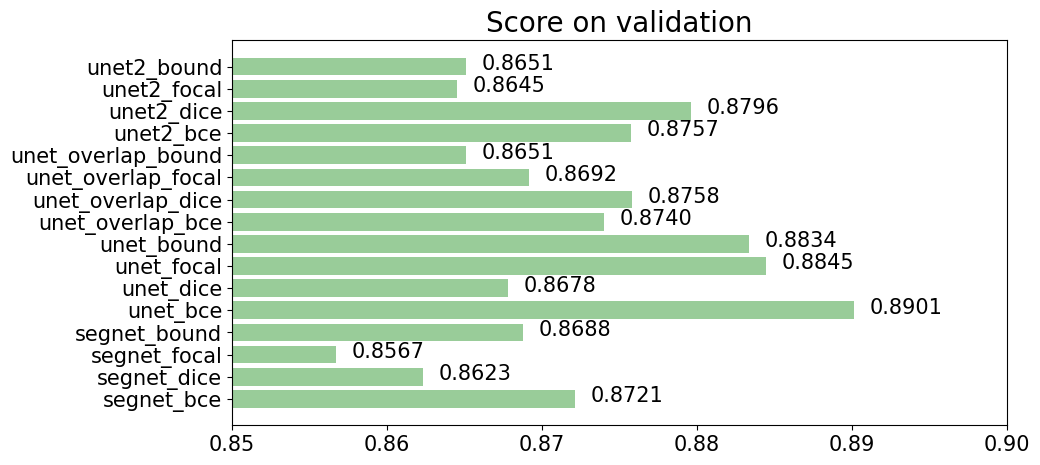

In [83]:
model_history().plot_val_scores(names)

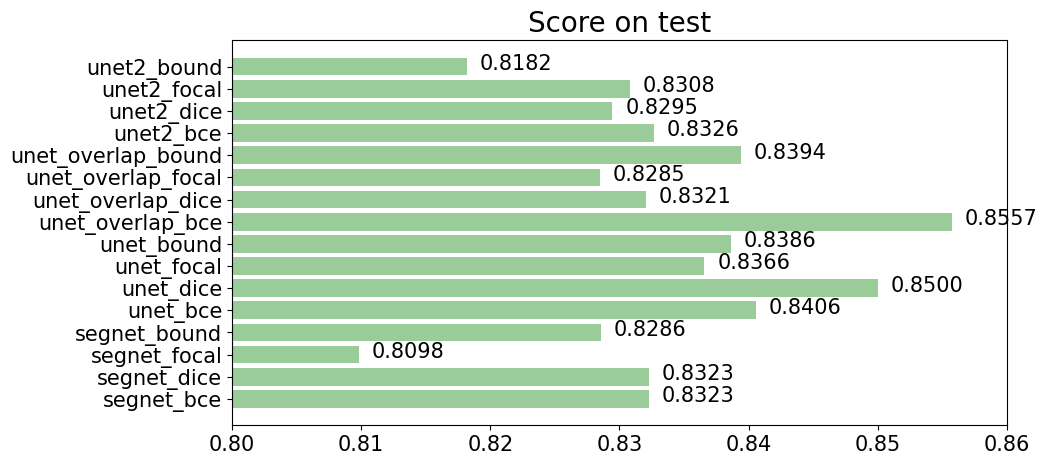

In [82]:
model_history().plot_test_scores(names)